The purpose of this notebook is to examine the clustering-based approach.
Steps include:
1. Train the Doc2Vec model in order to learn a feature representation capturing the semantic senses
2. Run K-Means five times, and identify the clusters about food environment
3. Evaluate K-Means models, and choose the best one

The following code is to train the Doc2Vec model

In [0]:
import pandas as pd
from nltk.stem import WordNetLemmatizer, SnowballStemmer

def read_data():
  
    dataframes=[]
    for i in range(15):
      dataframes.append(pd.read_csv('/gdrive/My Drive/Processed/Review%s.csv' % str(i+1), usecols=[1,4]))
    dataframe=pd.concat(dataframes, ignore_index=True)
    
    corpus = []
    for i, row in dataframe.iterrows():
        for sent in str(row[1]).split(','):
            corpus.append(sent.split(' '))
            
    return corpus


from gensim.models.doc2vec import Doc2Vec, TaggedDocument


def train_doc2vec(corpus):
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus)]
    model = Doc2Vec(documents, vector_size = 300, window = 4, dm = 0, dbow_words = 1, epoch = 10, min_count = 300, workers = 4)
    model.save('/gdrive/My Drive/Model/Doc2Vec')   
    
    return model
    

The training corpus is used to train Doc2Vec model

In [0]:
corpus=read_data()
model=train_doc2vec(corpus)

In [0]:
import pandas as pd
import nltk
from gensim.utils import simple_preprocess
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords

def preprocess(text):
    '''
    preprocess raw data: tokenization, remove stopwords, and lemmatization
    '''
    tokens = simple_preprocess(text)
    
    stop_words = stopwords.words('english')
    stop_words.extend(['london', 'leeds', 'u', 'would', 'could', 'us'])
    
    lemmatizer = WordNetLemmatizer()
    
    tokens = [lemmatizer.lemmatize(token, 'n') for token in tokens if token not in stop_words]
    return tokens

def predict(model, related_cluster, text):
    temp = model.infer_vector(l, epochs=60)
    if model.predict([temp])[0] == related_cluster:
      return 1
    return 0
    
def batch_predict(model, related_cluster, text_list):
    processed_list=[preprocess(text) for text in text_list]
    return [predict(model, related_topic, text) for text in processed_list]

The next snippets are to assess the performance of Doc2Vec.
I used it to find similiar texts with "So many restaurants very nearby that looked very nice."

In [8]:
l = preprocess("So many restaurants very nearby that looked very nice.")
temp = model.infer_vector(l, epochs=60)
model.docvecs.most_similar([temp])

for i, s in model.docvecs.most_similar([temp]):
  print(corpus[i])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


['many', 'good', 'restaurant', 'nearby', 'flat']
['many', 'restaurant', 'nearby', 'look', 'nice']
['lovely', 'apartment', 'nice', 'quiet', 'area', 'many', 'restaurant', 'shop', 'nearby']
['many', 'nice', 'restaurant', 'nearby']
['also', 'many', 'restaurant', 'nearby']
['lot', 'great', 'nice', 'restaurant', 'nearby']
['many', 'nice', 'restaurant']
['many', 'shop', 'nice', 'restaurant', 'nearby']
['many', 'nice', 'restaurant', 'nearby']
['many', 'restaurant', 'nearby']


Plot the figure of within-cluster variance against the number of clusters K in order to choose a optimal K.

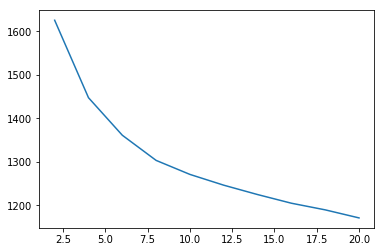

In [7]:
from sklearn.cluster import KMeans

X=[model[i] for i in range(10000)]

sse=[]
for n in range(2, 21, 2):
  clustering=KMeans(n_clusters=n, random_state=0).fit(X)
  sse.append(clustering.inertia_)
  
import matplotlib.pyplot as plt
plt.plot(range(2,21,2), sse)
plt.show()

Next, I run the K-Means clustering algorithm five times to choose the best model.

In [9]:
from sklearn.cluster import KMeans

X=[model[i] for i in range(10000)]
clustering_1=KMeans(n_clusters=20, random_state=10).fit(X)

for i in range(20):
  print(clustering_1.labels_[i], corpus[i])

13 ['lovely', 'stay', 'maia', 'home', 'welcome', 'maia', 'also', 'friendly', 'silvy', 'cat']
3 ['maia', 'keep', 'busy', 'club', 'sport', 'available', 'friendly', 'conversation', 'dinner', 'tv', 'comfortable', 'live', 'room']
15 ['maia', 'online', 'response', 'prompt']
12 ['room', 'large', 'storage', 'desk']
19 ['bed', 'comfortable']
12 ['also', 'storage', 'kitchen', 'available']
1 ['short', 'walk', 'house', 'armley', 'town', 'centre', 'store', 'bank', 'library']
1 ['city', 'reachable', 'via', 'direct', 'bus', 'route', 'hr', 'walk', 'feel', 'adventurous']
10 ['silvy', 'like', 'deposit', 'white', 'hair', 'clothe', 'suppose', 'blame', 'pet']
0 ['recommend', 'stay', 'someone', 'accustom', 'like', 'cat']
0 ['stay', 'maya', 'place', 'three', 'week']
5 ['great', 'experience']
0 ['time', 'good', 'place', 'live', 'also', 'nice', 'host', 'four', 'cat']
13 ['maya', 'hospitable', 'person']
11 ['help', 'lot', 'give', 'tip', 'city', 'even', 'show', 'around']
4 ['definitely', 'stay', 'next', 'time', 

In [10]:
df=pd.read_csv('/gdrive/My Drive/Test/test_extraction1.csv')
test_set=[str(r[0]) for i,r in df.iterrows()]
test_labels=[int(r[1]) for i,r in df.iterrows()]
predicted_labels=batch_predict(clustering_1, 14, test_set)

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
accuracy_score(test_labels, predicted_labels)
precision, recall, fscore=precision_recall_fscore_support(test_labels, predicted_labels, average='macro')
print("For first K-Means model:")
print("Accuracy: "+str(round(accuracy,3 ))"Precision: "+str(round(precision, 3)), "Recall: " +str(round(recall, 3)), "F-measure: " +str(round(fscore, 3)))

For first K-Means model:
Accuracy: 0.724 Precision: 0.639 Recall: 0.735 F-measure: 0.684


In [17]:
clustering_2=KMeans(n_clusters=20, random_state=11).fit(X)
for i in range(20):
  print(clustering_2.labels_[i], corpus[i])

13 ['lovely', 'stay', 'maia', 'home', 'welcome', 'maia', 'also', 'friendly', 'silvy', 'cat']
19 ['maia', 'keep', 'busy', 'club', 'sport', 'available', 'friendly', 'conversation', 'dinner', 'tv', 'comfortable', 'live', 'room']
6 ['maia', 'online', 'response', 'prompt']
5 ['room', 'large', 'storage', 'desk']
3 ['bed', 'comfortable']
5 ['also', 'storage', 'kitchen', 'available']
0 ['short', 'walk', 'house', 'armley', 'town', 'centre', 'store', 'bank', 'library']
2 ['city', 'reachable', 'via', 'direct', 'bus', 'route', 'hr', 'walk', 'feel', 'adventurous']
11 ['silvy', 'like', 'deposit', 'white', 'hair', 'clothe', 'suppose', 'blame', 'pet']
13 ['recommend', 'stay', 'someone', 'accustom', 'like', 'cat']
10 ['stay', 'maya', 'place', 'three', 'week']
16 ['great', 'experience']
13 ['time', 'good', 'place', 'live', 'also', 'nice', 'host', 'four', 'cat']
8 ['maya', 'hospitable', 'person']
9 ['help', 'lot', 'give', 'tip', 'city', 'even', 'show', 'around']
7 ['definitely', 'stay', 'next', 'time', '

In [11]:
predicted_labels=batch_predict(clustering_2, 0, test_set)

accuracy_score(test_labels, predicted_labels)
precision, recall, fscore=precision_recall_fscore_support(test_labels, predicted_labels, average='macro')
print("For second K-Means model:")
print("Accuracy: "+str(round(accuracy,3 ))"Precision: "+str(round(precision, 3)), "Recall: " +str(round(recall, 3)), "F-measure: " +str(round(fscore, 3)))

For first K-Means model:
Accuracy: 0.731 Precision: 0.654 Recall: 0.723 F-measure: 0.687


In [20]:
clustering_3=KMeans(n_clusters=20, random_state=12).fit(X)
for i in range(20):
  print(clustering_3.labels_[i], corpus[i])

2 ['lovely', 'stay', 'maia', 'home', 'welcome', 'maia', 'also', 'friendly', 'silvy', 'cat']
3 ['maia', 'keep', 'busy', 'club', 'sport', 'available', 'friendly', 'conversation', 'dinner', 'tv', 'comfortable', 'live', 'room']
1 ['maia', 'online', 'response', 'prompt']
7 ['room', 'large', 'storage', 'desk']
8 ['bed', 'comfortable']
7 ['also', 'storage', 'kitchen', 'available']
13 ['short', 'walk', 'house', 'armley', 'town', 'centre', 'store', 'bank', 'library']
6 ['city', 'reachable', 'via', 'direct', 'bus', 'route', 'hr', 'walk', 'feel', 'adventurous']
15 ['silvy', 'like', 'deposit', 'white', 'hair', 'clothe', 'suppose', 'blame', 'pet']
19 ['recommend', 'stay', 'someone', 'accustom', 'like', 'cat']
5 ['stay', 'maya', 'place', 'three', 'week']
16 ['great', 'experience']
5 ['time', 'good', 'place', 'live', 'also', 'nice', 'host', 'four', 'cat']
2 ['maya', 'hospitable', 'person']
9 ['help', 'lot', 'give', 'tip', 'city', 'even', 'show', 'around']
19 ['definitely', 'stay', 'next', 'time', 'vi

In [12]:
predicted_labels=batch_predict(clustering_3, 13, test_set)

accuracy_score(test_labels, predicted_labels)
precision, recall, fscore=precision_recall_fscore_support(test_labels, predicted_labels, average='macro')
print("For third K-Means model:")
print("Accuracy: "+str(round(accuracy,3 ))"Precision: "+str(round(precision, 3)), "Recall: " +str(round(recall, 3)), "F-measure: " +str(round(fscore, 3)))

For first K-Means model:
Accuracy: 0.749 Precision: 0.660 Recall: 0.759 F-measure: 0.706


In [21]:
clustering_4=KMeans(n_clusters=20, random_state=13).fit(X)
for i in range(20):
  print(clustering_4.labels_[i], corpus[i])

13 ['lovely', 'stay', 'maia', 'home', 'welcome', 'maia', 'also', 'friendly', 'silvy', 'cat']
5 ['maia', 'keep', 'busy', 'club', 'sport', 'available', 'friendly', 'conversation', 'dinner', 'tv', 'comfortable', 'live', 'room']
10 ['maia', 'online', 'response', 'prompt']
17 ['room', 'large', 'storage', 'desk']
3 ['bed', 'comfortable']
17 ['also', 'storage', 'kitchen', 'available']
2 ['short', 'walk', 'house', 'armley', 'town', 'centre', 'store', 'bank', 'library']
8 ['city', 'reachable', 'via', 'direct', 'bus', 'route', 'hr', 'walk', 'feel', 'adventurous']
15 ['silvy', 'like', 'deposit', 'white', 'hair', 'clothe', 'suppose', 'blame', 'pet']
13 ['recommend', 'stay', 'someone', 'accustom', 'like', 'cat']
6 ['stay', 'maya', 'place', 'three', 'week']
16 ['great', 'experience']
13 ['time', 'good', 'place', 'live', 'also', 'nice', 'host', 'four', 'cat']
18 ['maya', 'hospitable', 'person']
1 ['help', 'lot', 'give', 'tip', 'city', 'even', 'show', 'around']
14 ['definitely', 'stay', 'next', 'time'

In [14]:
predicted_labels=batch_predict(clustering_4, 2, test_set)

accuracy_score(test_labels, predicted_labels)
precision, recall, fscore=precision_recall_fscore_support(test_labels, predicted_labels, average='macro')
print("For fourth K-Means model:")
print("Accuracy: "+str(round(accuracy,3 ))"Precision: "+str(round(precision, 3)), "Recall: " +str(round(recall, 3)), "F-measure: " +str(round(fscore, 3)))

For first K-Means model:
Accuracy: 0.727 Precision: 0.645 Recall: 0.731 F-measure: 0.685


In [22]:
clustering_5=KMeans(n_clusters=20, random_state=14).fit(X)
for i in range(20):
  print(clustering_5.labels_[i], corpus[i])

3 ['lovely', 'stay', 'maia', 'home', 'welcome', 'maia', 'also', 'friendly', 'silvy', 'cat']
11 ['maia', 'keep', 'busy', 'club', 'sport', 'available', 'friendly', 'conversation', 'dinner', 'tv', 'comfortable', 'live', 'room']
9 ['maia', 'online', 'response', 'prompt']
8 ['room', 'large', 'storage', 'desk']
10 ['bed', 'comfortable']
8 ['also', 'storage', 'kitchen', 'available']
14 ['short', 'walk', 'house', 'armley', 'town', 'centre', 'store', 'bank', 'library']
7 ['city', 'reachable', 'via', 'direct', 'bus', 'route', 'hr', 'walk', 'feel', 'adventurous']
16 ['silvy', 'like', 'deposit', 'white', 'hair', 'clothe', 'suppose', 'blame', 'pet']
15 ['recommend', 'stay', 'someone', 'accustom', 'like', 'cat']
13 ['stay', 'maya', 'place', 'three', 'week']
1 ['great', 'experience']
13 ['time', 'good', 'place', 'live', 'also', 'nice', 'host', 'four', 'cat']
3 ['maya', 'hospitable', 'person']
12 ['help', 'lot', 'give', 'tip', 'city', 'even', 'show', 'around']
15 ['definitely', 'stay', 'next', 'time',

In [15]:
predicted_labels=batch_predict(clustering_5, 14, test_set)

accuracy_score(test_labels, predicted_labels)
precision, recall, fscore=precision_recall_fscore_support(test_labels, predicted_labels, average='macro')
print("For fifth K-Means model:")
print("Accuracy: "+str(round(accuracy,3 ))"Precision: "+str(round(precision, 3)), "Recall: " +str(round(recall, 3)), "F-measure: " +str(round(fscore, 3)))

For first K-Means model:
Accuracy: 0.731 Precision: 0.654 Recall: 0.724 F-measure: 0.687
